# Chapter 5 Exercises

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

In [2]:
plt.style.use('bmh')
az.style.use('bmh')
plt.rcParams['figure.figsize'] = (16, 8)
np.random.seed(123)

## Exercise 1
***

*This exercise is about regularization priors. In the code that generates the data, change `order=2` to another value, such as `order=5`. Then, fit `model_p` and plot the resulting curve.* 

*Repeat this, but now using a prior for beta with `sd=100` instead of `sd=1` and plot the resulting curve.*

*How are both curves different? Try this out with `sd=np.array([10, 0.1, 0.1, 0.1, 0.1])`, too*

In [61]:
from sklearn.preprocessing import StandardScaler


dummy_data = np.loadtxt('../code/data/dummy.csv')
x, y = np.split(ary=dummy_data, axis=1, indices_or_sections=dummy_data.shape[1])

order = 5
power = np.repeat(a=np.arange(1, order + 1).reshape(-1, 1), repeats=x.shape[0], axis=1)
x_p = np.power(x.T, power).T

x_ps = np.split(ary=StandardScaler().fit_transform(x_p),
                     axis=1, indices_or_sections=x_p.shape[1])
y_s = StandardScaler().fit_transform(y)

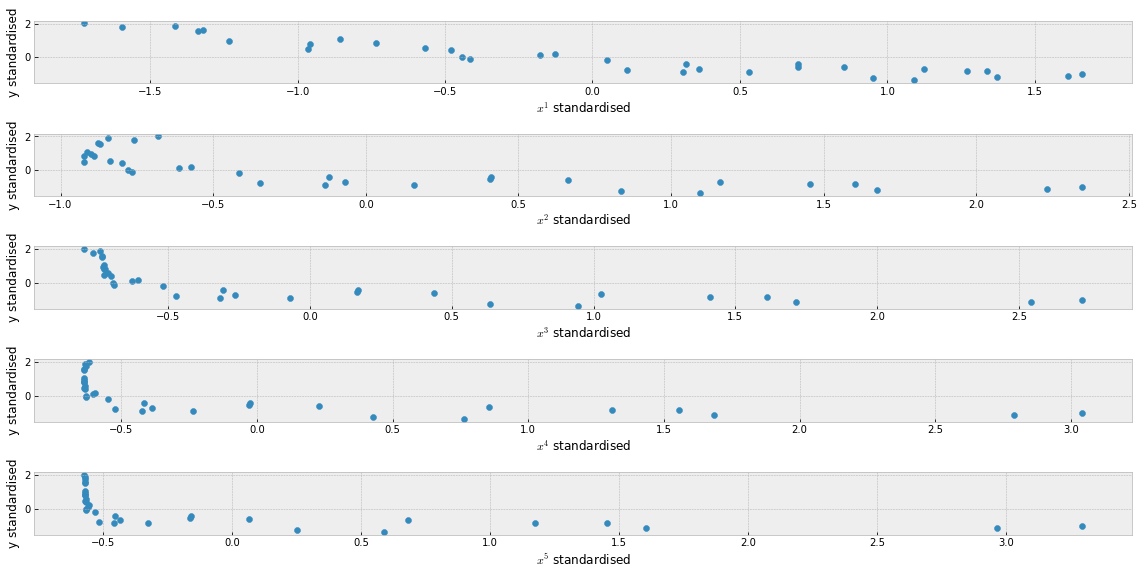

In [62]:
_, ax = plt.subplots(nrows=len(x_ps), sharey='col',)

for i, xs in enumerate(x_ps):
    ax[i].scatter(x=xs, y=y_s);
#     ax[i].set_title(f'order = {i+1}')
    ax[i].set_ylabel('y standardised');
    ax[i].set_xlabel(f'$x^{i+1}$ standardised');
    
plt.tight_layout()

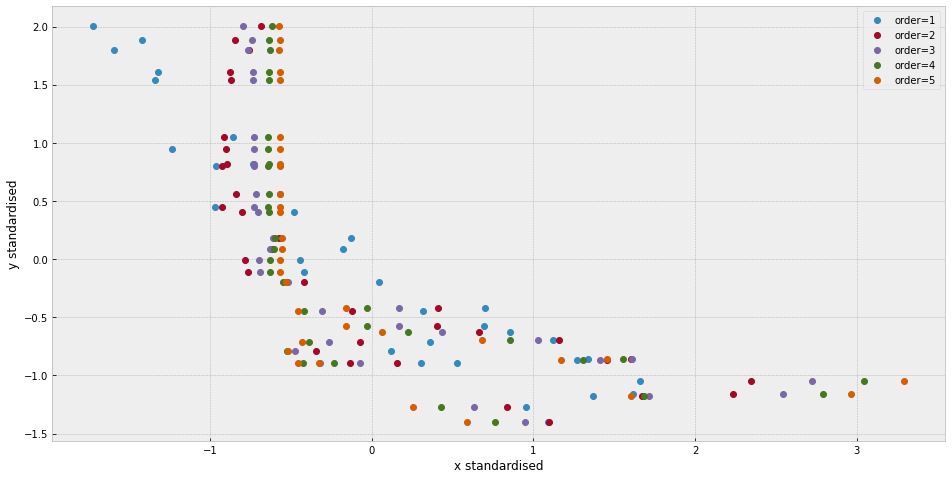

In [63]:
for i in range(len(x_ps)):
#     plt.scatter(x=x_ps[i], y=[y_s], marker='o')
    plt.plot(x_ps[i], y_s, 'o', label=f'order={i+1}')  
    
plt.ylabel('y standardised');
plt.xlabel('x standardised');
plt.legend();    

In [64]:
with pm.Model() as model_p:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)

    μ = pm.Deterministic('μ', α + pm.math.dot(β, np.stack(x_ps, axis=0).squeeze(-1)))

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_s)

    trace_p = pm.sample(draws=2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [03:58<00:00, 25.13draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [74]:
# i = 0

# plt.plot(x_ps[i], y_s, 'o', label=f'order={i+1}')  
# az.plot_hpd(x=x_ps[i].squeeze(-1), y=trace_p['μ']);

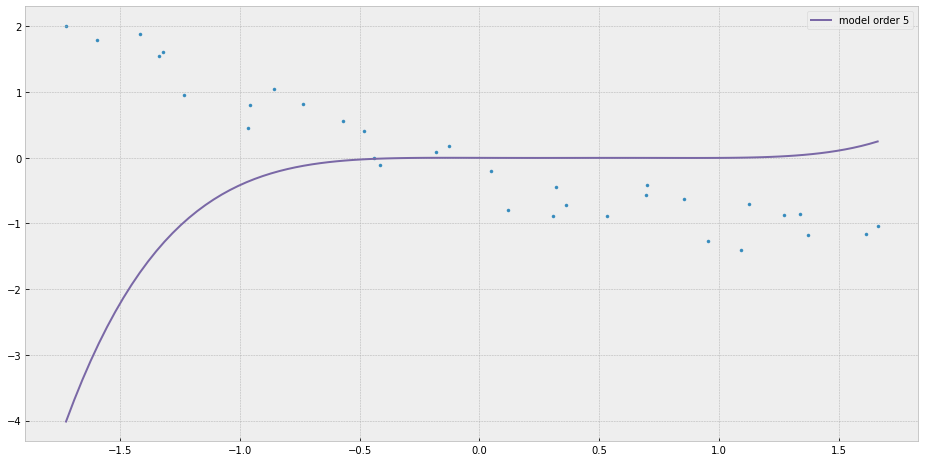

In [82]:
x_new = np.linspace(x_ps[0].min(), x_ps[0].max(), 100)


α_p_post = trace_p['α'].mean()
β_p_post = trace_p['β'].mean(axis=0)
# idx = np.argsort(x_1s[0])
y_p_post = α_p_post + np.dot(β_p_post, np.stack(x_ps, axis=0).squeeze(-1))
plt.plot(x_ps[0], y_p_post, 'C2', label=f'model order {order}')


x_new_p = np.vstack([x_new**i for i in range(1, order+1)])
y_p_post = α_p_post + np.dot(β_p_post, x_new_p) 
plt.plot(x_new_p[0], y_p_post, 'C2', label=f'model order {order}')


plt.scatter(x_ps[0], y_s, c='C0', marker='.')
plt.legend();

## Exercise 2
***

*Repeat the previous exercise but increase the amount of data to 500 data points.*

In [6]:
y_l = pm.sample_posterior_predictive(trace_l, 2000,
                                     model=model_l)['y_pred']

y_p = pm.sample_posterior_predictive(trace_p, 2000,
                                     model=model_p)['y_pred']

/home/osvaldo/proyectos/00_PyMC3/pymc3/pymc3/sampling.py:1100: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn("samples parameter is smaller than nchains times ndraws, some draws "


/home/osvaldo/proyectos/00_PyMC3/pymc3/pymc3/sampling.py:1100: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn("samples parameter is smaller than nchains times ndraws, some draws "


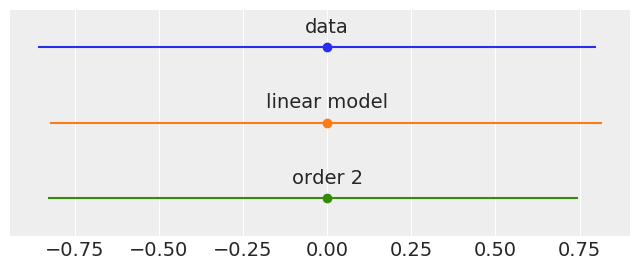

In [7]:
plt.figure(figsize=(8, 3))
data = [y_1s, y_l, y_p]
labels = ['data', 'linear model', 'order 2']
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)
plt.ylim([-i-0.5, 0.5])
plt.yticks([])
plt.savefig('B11197_05_03.png', dpi=300)

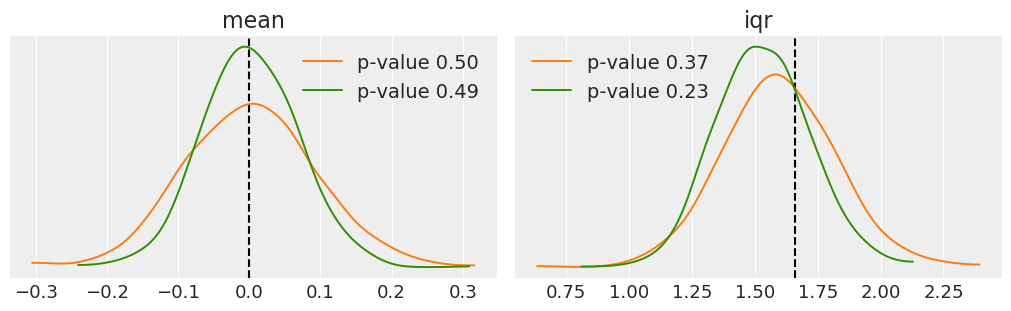

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)


def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))


for idx, func in enumerate([np.mean, iqr]):
    T_obs = func(y_1s)
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    for d_sim, c in zip([y_l, y_p], ['C1', 'C2']):
        T_sim = func(d_sim, 1)
        p_value = np.mean(T_sim >= T_obs)
        az.plot_kde(T_sim, plot_kwargs={'color': c},
                    label=f'p-value {p_value:.2f}', ax=ax[idx])
    ax[idx].set_title(func.__name__)
    ax[idx].set_yticks([])
    ax[idx].legend()
plt.savefig('B11197_05_04.png', dpi=300)

## Exercise 3
***

*Fit a cubic model (order 3), compute WAIC and LOO, plot the results, and compare them with the linear and quadratic models.*

## Exercise 4
***

*Use `pm.sample_posterior_predictive()` to rerun the PPC example, but this time, plot the values of `y` instead of the values of the mean.*

## Exercise 8
***

*Compute the Bayes factor for the coin problem using a uniform prior beta (1, 1) and priors such as beta (0.5, 0.5). Set 15 heads and 30 coins. Compare this result with the inference we got in the first chapter of this book.*

In [3]:
coins = 30
heads = 15 
y_d = np.repeat([0, 1], [coins-heads, heads])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [4]:
# with pm.Model() as model_BF:
#     p = np.array([0.5, 0.5])
#     model_index = pm.Categorical('model_index', p=p)

#     m_0 = (4, 8)
#     m_1 = (8, 4)
#     m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)

#     # a priori
#     θ = pm.Beta('θ', m[0], m[1])
#     # likelihood
#     y = pm.Bernoulli('y', θ, observed=y_d)

#     trace_BF = pm.sample(5000)
# az.plot_trace(trace_BF)


In [7]:
# pM1 = trace_BF['model_index'].mean()
# pM0 = 1 - pM1
# BF = (pM0 / pM1) * (p[1] / p[0])
# BF

In [8]:
with pm.Model() as model_BF_0:
    θ = pm.Beta(name='θ', alpha=1, beta=1)
    y = pm.Bernoulli(name='y', p=θ, observed=y_d)
    trace_BF_0 = pm.sample_smc()

with pm.Model() as model_BF_1:
    θ = pm.Beta(name='θ', alpha=0.5, beta=0.5)
    y = pm.Bernoulli(name='y', p=θ, observed=y_d)
    trace_BF_1 = pm.sample_smc()

Sample initial stage: ...
Stage:   0 Beta: 0.308 Steps:  25 Acce: 1.000
Stage:   1 Beta: 1.000 Steps:  25 Acce: 0.680
Sample initial stage: ...
Stage:   0 Beta: 0.144 Steps:  25 Acce: 1.000
Stage:   1 Beta: 1.000 Steps:  25 Acce: 0.693


In [9]:
model_BF_0.marginal_likelihood / model_BF_1.marginal_likelihood

1.3866450518489124

## Exercise 9
***

*Repeat the last example where we compare Bayes factors and Information Criteria, but now reduce the sample size.*

In [16]:
traces = []
waics = []
model_names = []
for coins, heads in [(10, 3), (100, 30)]:
    y_d = np.repeat([0, 1], [coins-heads, heads])
    for priors in [(4, 8), (8, 4)]:
        with pm.Model() as model:
            θ = pm.Beta('θ', *priors)
            y = pm.Bernoulli('y', θ, observed=y_d)
            trace = pm.sample(2000)
            model_names.append(f"{coins}_{priors}")
            traces.append(trace)
            waics.append(az.waic(trace))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:02<00:00, 1717.69draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:03<00:00, 1522.81draws/s]
The acceptance probability does not match the target. It is 0.8880941551754923, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:03<00:00, 1576.90draws/s]
The acceptance probability does not match the target. It is 0.8812094876638814, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not 

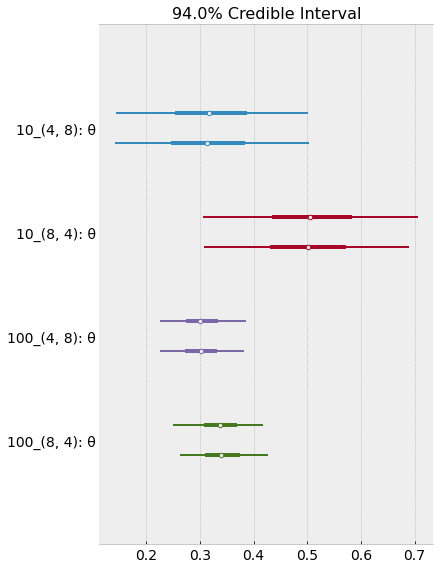

In [18]:
az.plot_forest(traces, model_names=model_names);

In [21]:
# az.compare(dataset_dict=dict(zip(model_names, traces)))

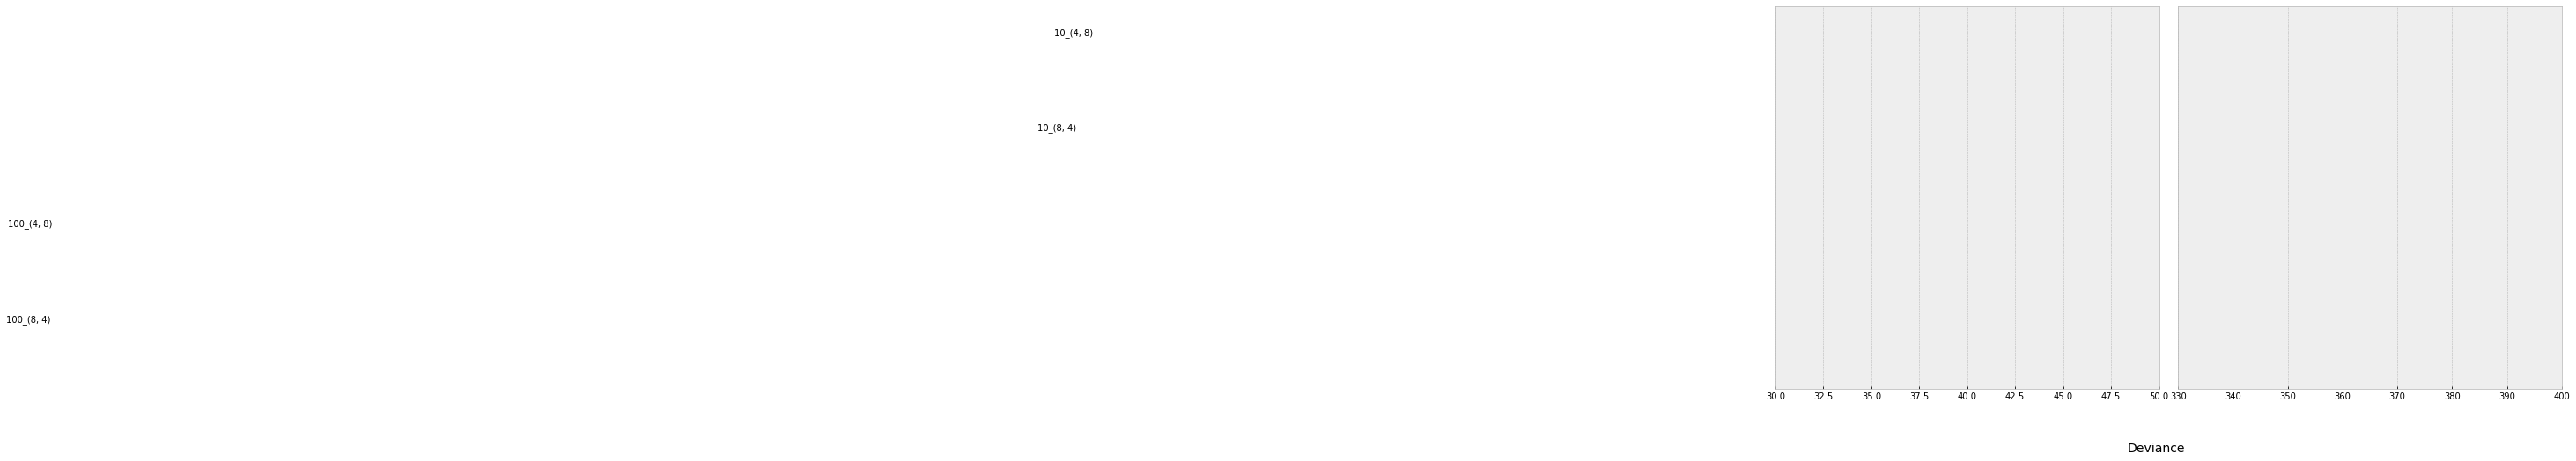

In [26]:
fig, ax = plt.subplots(1, 2, sharey=True)

labels = model_names
indices = [0, 0, 1, 1]
for i, (ind, d) in enumerate(zip(indices, waics)):
    mean = d.waic
    ax[ind].errorbar(mean, -i, xerr=d.waic_se, fmt='o')
    ax[ind].text(mean, -i+0.2, labels[i], ha='center')

ax[0].set_xlim(30, 50)
ax[1].set_xlim(330, 400)
plt.ylim([-i-0.5, 0.5])
plt.yticks([])
plt.subplots_adjust(wspace=0.05)
fig.text(0.5, 0, 'Deviance', ha='center', fontsize=14);

## Exercise 10
***

*For the entropy example, change the `q` distribution. Try this with distributions like `stats.binom(10, 0.5)` and `stats.binom(10, 0.25)`.*